In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Define the loss function 
`mse_loss(predi, label, kernel_size, kernel_sigma)`

We will use the MSE loss between the prediction and the label that both convolved with a samll Gaussian kernel. Thus, we first define our Gaussian kernel and use the kernel to perform Gaussian blur.

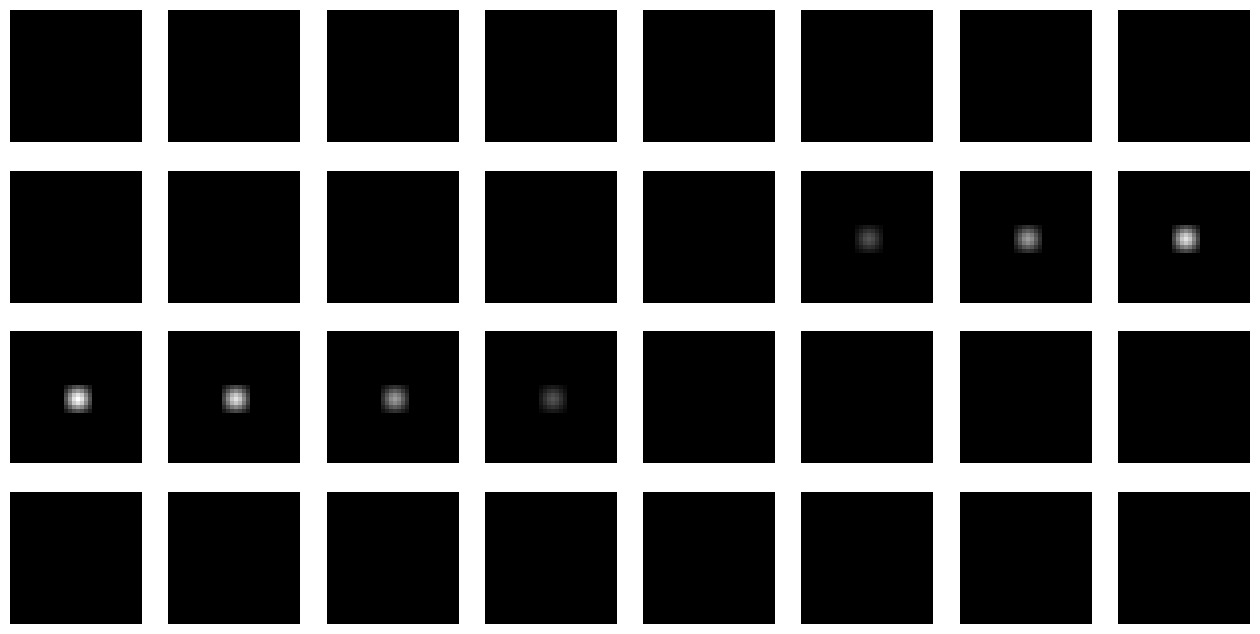

In [2]:
def gaussian_kernel(dim, size, sigma):
    # build 1D Gaussian kernel
    coord = torch.linspace(-(size // 2), (size // 2), size)
    kernel_1d  = torch.exp((-(coord / sigma)**2 / 2))
    kernel_1d /= kernel_1d.sum()  # Normalization

    # build nd Gaussian kernel using einsum
    equation = ','.join(f'{chr(97 + i)}' for i in range(dim))
    operands = [kernel_1d for _ in range(dim)]
    kernel_nd  = torch.einsum(equation, *operands)
    kernel_nd /= kernel_nd.sum()  # Normalization

    return kernel_nd  

def gaussian_blur_3d(frame, kernel_size, kernel_sigma):
    kernel = gaussian_kernel(frame.dim(), kernel_size, kernel_sigma)
    return F.conv3d(
        frame.reshape(1, 1, *frame.shape), 
        kernel.reshape(1, 1, *kernel.shape), 
        stride=1, padding=kernel_size//2).reshape(*frame.shape)

# test the gaussian_blur_3d function
frame = torch.zeros([32, 32, 32])
frame[16, 16, 16] = 1
frame = gaussian_blur_3d(frame, 7, 1)
frame /= torch.amax(frame)
# plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    row = i // 8
    col = i % 8
    axes[row, col].imshow(frame[i, :, :], cmap='gray', vmin=0, vmax=1)
    axes[row, col].axis('off')
plt.show()

Using this Gaussian blur help function, we define the loss function. We will using the summation of elemental wise MSE as out return value since the loss of our frame is not depend on pixel number. 

In [3]:
def mse_loss(predi, label, kernel_size, kernel_sigma):
    return F.mse_loss(
        gaussian_blur_3d(label, kernel_size, kernel_sigma), 
        gaussian_blur_3d(predi, kernel_size, kernel_sigma), 
        reduction='none').sum()

### Relation to luminance

Set the frame dimension as 32 32 32 and the luminance as 0 except (16, 16, 16) as 0.5. Fix the kernel size at 7 and sigma at 1. We shift the luminance of prediction at the same location from 0 to 1 with step size 0.1. The plot below show the relation between the luminance and the loss. 

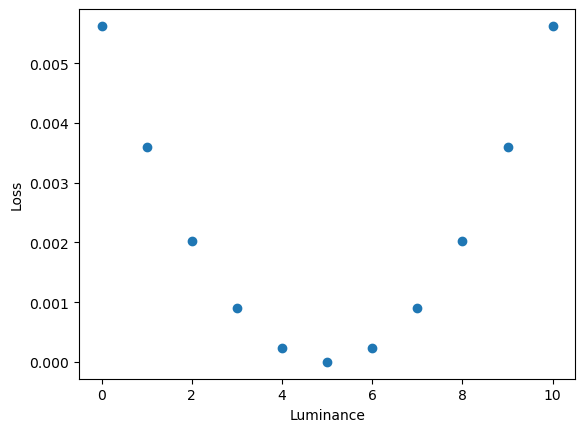

In [4]:
label = torch.zeros([32, 32, 32])
label[16, 16, 16] = 0.5

loss_set = []
for lum in range(0, 11):
    predi = torch.zeros([32, 32, 32])
    predi[16, 16, 16] = lum / 10
    loss_set.append(mse_loss(predi, label, 7, 1))
plt.plot(loss_set, 'o')
plt.xlabel('Luminance')
plt.ylabel('Loss')
plt.show()

### Relation to the position

`mse_loss_pad(predi, label, kernel_size, kernel_sigma)`

Now, we shife the predicting location of first dimension from 0 to 32. The plot below show the relation between the predict position and the loss. 

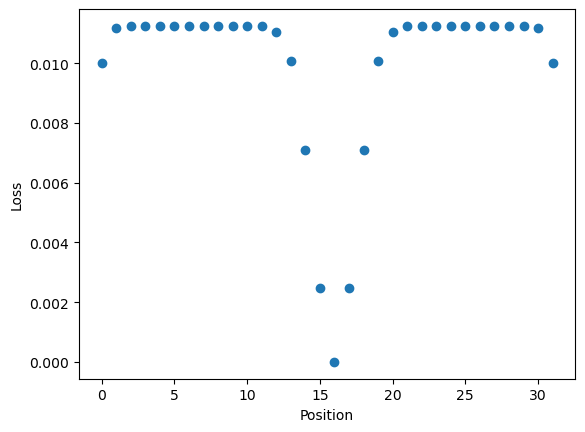

In [11]:
loss_set = []
for x in range(0, 32):
    predi = torch.zeros([32, 32, 32])
    predi[x, 16, 16] = 0.5
    loss_set.append(mse_loss(predi, label, 7, 1))
    torch.set_printoptions(precision=10)
plt.plot(loss_set, 'o')
plt.xlabel('Position')
plt.ylabel('Loss')
plt.show()

Two problems appear here. First, the gradiant of loss is zero or very small when the position shift too much. However, this will not affect the optimization since we still have gradiant at the luminance. In fact, one of the reason we treat the locolization problem as regression problem instead of classification problem since the luminance can provide a gradiant to loss and the pixel that far away from the label will trend to have 0 for luminance. Next part provides an illustration to that. 

Second, there is a local minimum when the predict position too close to the boundary of the frame since half of the gaussian kernel is masked by the boundary of the frame. Thus, we need a tiny modification to the loss function where we pad the prediction frame `predi` and `label` by `kernel_size` before Gaussian blur. 

Some example about the above problem is available here where we use MSE loss between prediction and label that convolve with a Gaussian kernel with size `3` and sigma `(1, 1)`. The branch size is `10`, num of train and validation data is `5000` and `1250`. After 24 epoch trainning and plot the prediction result of each epoch, we find that the predicted pixels tend to place at the boundary of the frame. Same result happen in the first frame generate by `DataLoader(SimDataset(Config(), 1),)` with NumPy random seed set at [0](assets/Logs/Jun-8/0-3-[1,1].tif), [4](assets/Logs/Jun-8/4-3-[1,1].tif), [5](assets/Logs/Jun-8/5-3-[1,1].tif), and [6](assets/Logs/Jun-8/6-3-[1,1].tif). 

In [6]:
def mse_loss_pad(predi, label, kernel_size, kernel_sigma):
    pad_size = [kernel_size for _ in range(6)]
    return F.mse_loss(
        gaussian_blur_3d(F.pad(predi, pad_size), kernel_size, kernel_sigma), 
        gaussian_blur_3d(F.pad(label, pad_size), kernel_size, kernel_sigma), 
        reduction='none').sum()

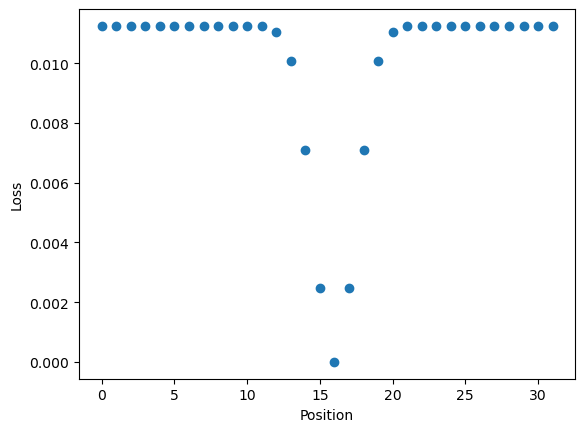

In [13]:
loss_set = []
for x in range(0, 32):
    predi = torch.zeros([32, 32, 32])
    predi[x, 16, 16] = 0.5
    loss_set.append(mse_loss_pad(predi, label, 7, 1))
plt.plot(loss_set, 'o')
plt.xlabel('Position')
plt.ylabel('Loss')
plt.show()

### Relation to the luminance and position

Now, we shife the predicting location from 0 pixel to 5 pixel; for each prediction, we then shift the luminance of the predict pixel from 0 to 1 with step size 0.1. The plot below show the relation between the luminance and the loss. 

As the predict position shift from the label, the luminance trend to be 0 in order to decrease the loss value. Thus, the position that shift from label too much will still have gradiant from luminance. 

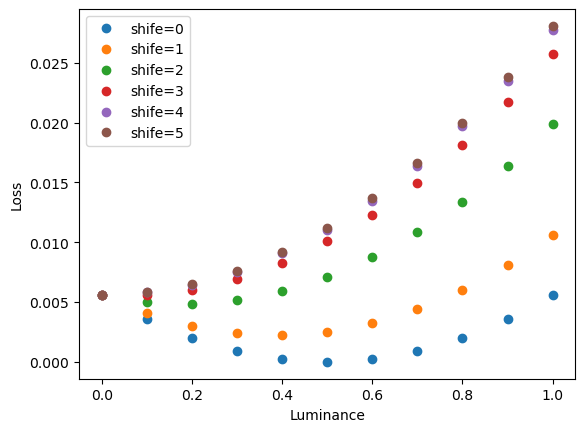

In [45]:
for shift in range(6):
    loss_set = []
    for lum in range(0, 11):
        predi = torch.zeros([32, 32, 32])
        predi[16-shift, 16, 16] = lum / 10
        loss_set.append(mse_loss(predi, label, 7, 1))
    plt.plot(
        np.linspace(0, 10, 11)/10, loss_set, 'o', 
        label="shife={}".format(shift))
plt.xlabel('Luminance')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Relation to the kernel sigma and position

Now, we fix the predict pixel of first dimension at 14 and lum at 0.5. The plot below show how different kernel sigma affect the loss function. 

Smaller sigma provide more gradiant to the loss function, which accelerate the convergence of network. Thus, it's reasonable to set the sigma at `1` or `2`

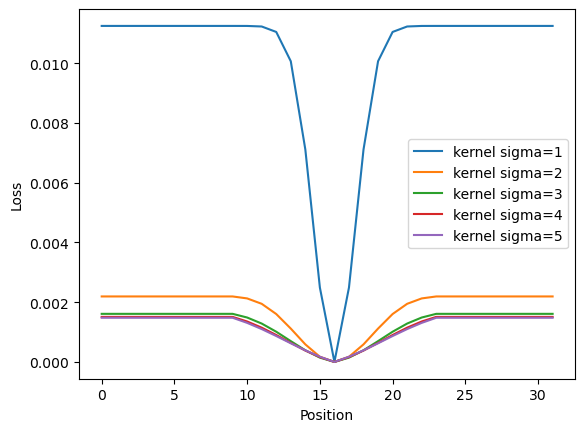

In [26]:
for sigma in range(1, 6):
    loss_set = []
    for x in range(0, 32):
        predi = torch.zeros([32, 32, 32])
        predi[x, 16, 16] = 0.5
        loss_set.append(mse_loss_pad(predi, label, 7, sigma))
    plt.plot(loss_set, label="kernel sigma={}".format(sigma))
plt.xlabel('Position')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Relation to the kernel size and position

Now, we fix the predict pixel of first dimension at 14 and lum at 0.5. The plot below show how different kernel size affect the loss function.

We observe that larger kernel size will provide more gradiant to the loss function but increase the computational time. Note that as the size increase, the marginal gradiant that the kernel size gives to us decrease dramatically. Thus, it's reasonable to set the kernel size around `7` depend on computer resource. 

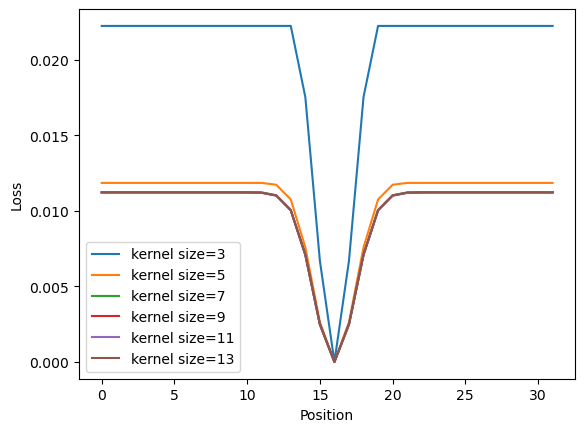

In [30]:
for size in range(3, 15, 2):
    loss_set = []
    for x in range(0, 32):
        predi = torch.zeros([32, 32, 32])
        predi[x, 16, 16] = 0.5
        loss_set.append(mse_loss_pad(predi, label, size, 1))
    plt.plot(loss_set, label="kernel size={}".format(size))
plt.xlabel('Position')
plt.ylabel('Loss')
plt.legend()
plt.show()